# Wojciech Labedz, Urszula Kostuch - projekt 6

### zad za 6 pkt

=== ROZSZERZONY EKSPERYMENT MULTI-AGENT CONNECT FOUR ===

EKSPERYMENT 1: PPO - Porównanie wariantów hiperparametrów
Trenowanie PPO_Conservative...
[WARNING]: Illegal move made, game terminating with current player losing. 
obs['action_mask'] contains a mask of all legal moves that can be chosen.
[WARNING]: Illegal move made, game terminating with current player losing. 
obs['action_mask'] contains a mask of all legal moves that can be chosen.
[WARNING]: Illegal move made, game terminating with current player losing. 
obs['action_mask'] contains a mask of all legal moves that can be chosen.
[WARNING]: Illegal move made, game terminating with current player losing. 
obs['action_mask'] contains a mask of all legal moves that can be chosen.
[WARNING]: Illegal move made, game terminating with current player losing. 
obs['action_mask'] contains a mask of all legal moves that can be chosen.
[WARNING]: Illegal move made, game terminating with current player losing. 
obs['action_mask'] contains

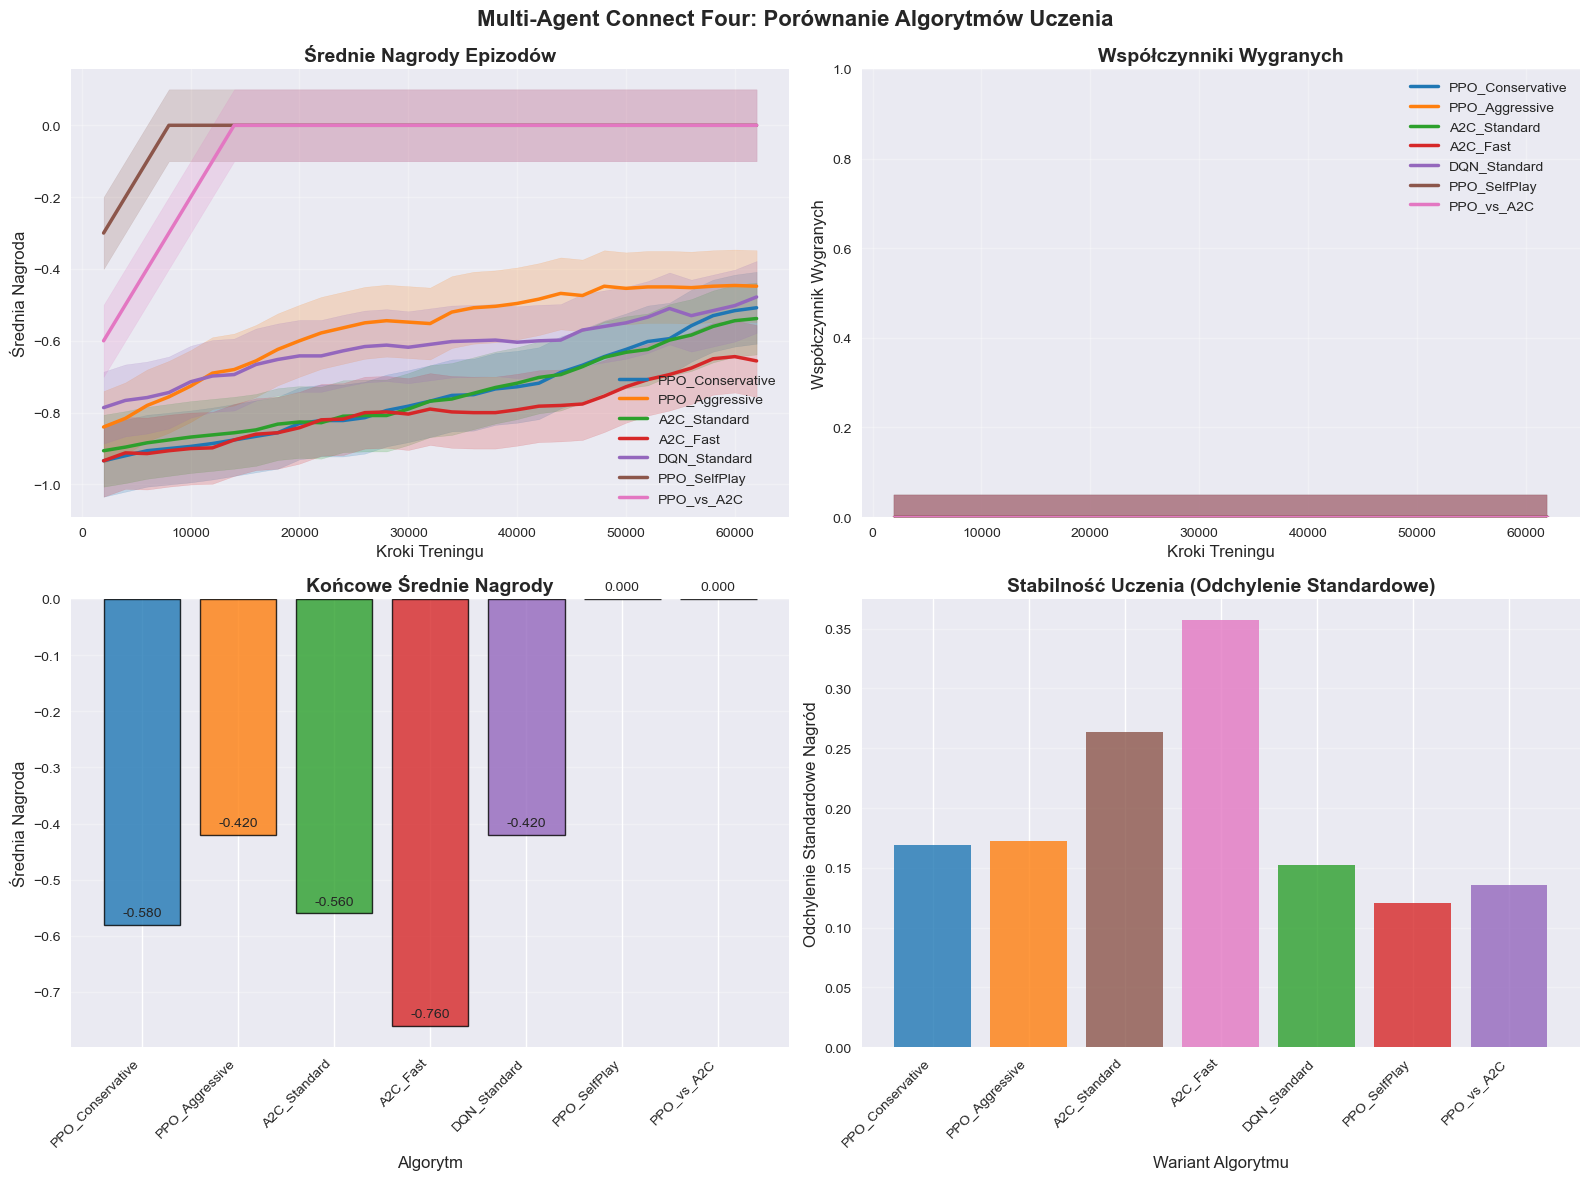

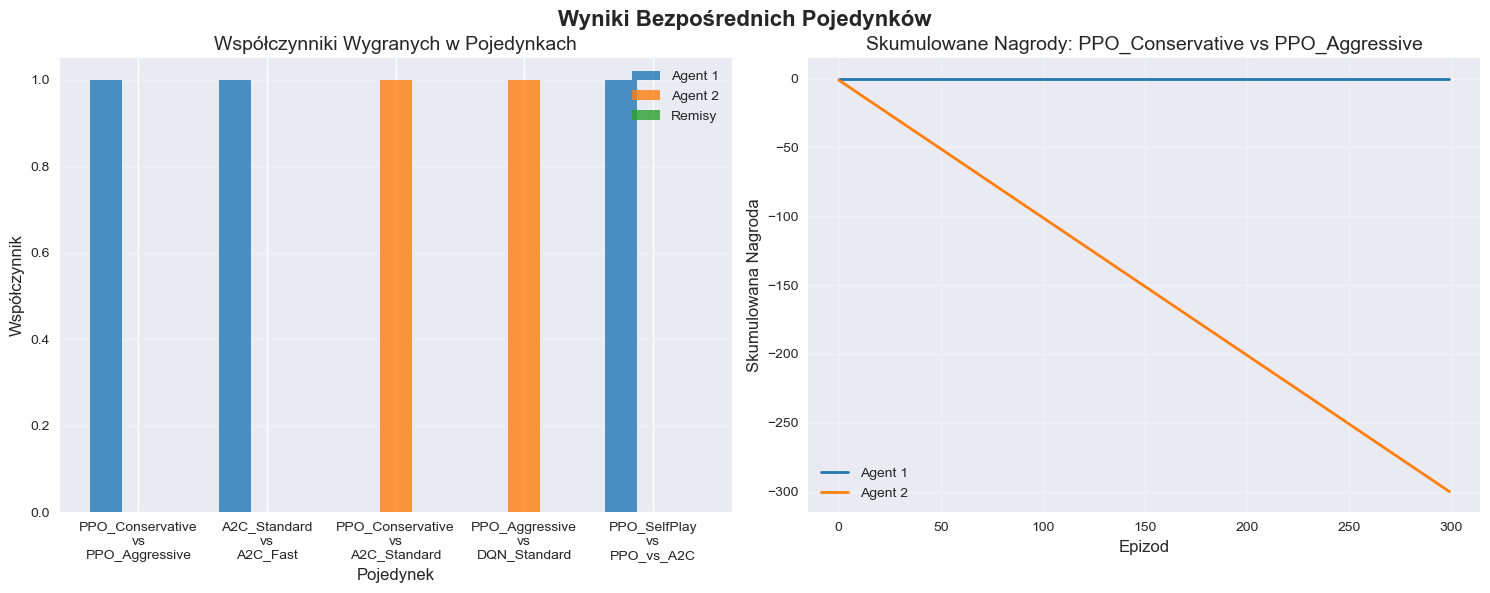


 RAPORT EKSPERYMENTU MULTI-AGENT CONNECT FOUR

1. ALGORYTMY I WARIANTY:
----------------------------------------
   PPO_Conservative:
      - Algorytm: PPO
      - Typ przeciwnika: random
      - Hiperparametry: {'learning_rate': 0.0001, 'n_steps': 4096, 'batch_size': 32}
   PPO_Aggressive:
      - Algorytm: PPO
      - Typ przeciwnika: random
      - Hiperparametry: {'learning_rate': 0.001, 'n_steps': 1024, 'batch_size': 128}
   A2C_Standard:
      - Algorytm: A2C
      - Typ przeciwnika: random
      - Hiperparametry: {'learning_rate': 0.0007, 'n_steps': 5}
   A2C_Fast:
      - Algorytm: A2C
      - Typ przeciwnika: random
      - Hiperparametry: {'learning_rate': 0.001, 'n_steps': 20}
   DQN_Standard:
      - Algorytm: DQN
      - Typ przeciwnika: random
      - Hiperparametry: {'learning_rate': 0.0005, 'exploration_fraction': 0.2}
   PPO_SelfPlay:
      - Algorytm: PPO
      - Typ przeciwnika: self
   PPO_vs_A2C:
      - Algorytm: PPO
      - Typ przeciwnika: different

2. KOŃCOWE

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pettingzoo.classic import connect_four_v3
import gymnasium as gym
from stable_baselines3 import PPO, A2C, DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback
import pickle
import os
from typing import Dict, List, Tuple
import json
from collections import defaultdict
import seaborn as sns

# Ustawienia dla ładnych wykresów
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class TrainingCallback(BaseCallback):
    """Callback do śledzenia postępów treningu"""
    
    def __init__(self, eval_freq=1000, eval_episodes=50):
        super().__init__()
        self.eval_freq = eval_freq
        self.eval_episodes = eval_episodes
        self.evaluations = []
        self.timesteps = []
        self.episode_rewards = []
        self.win_rates = []
        
    def _on_step(self) -> bool:
        if self.n_calls % self.eval_freq == 0:
            # Szybka ewaluacja
            wins = 0
            total_reward = 0
            
            for _ in range(self.eval_episodes):
                obs = self.training_env.reset()
                done = False
                episode_reward = 0
                
                while not done:
                    action, _ = self.model.predict(obs, deterministic=True)
                    obs, reward, done, info = self.training_env.step(action)
                    episode_reward += reward[0] if isinstance(reward, np.ndarray) else reward
                
                total_reward += episode_reward
                if episode_reward > 0:
                    wins += 1
            
            avg_reward = total_reward / self.eval_episodes
            win_rate = wins / self.eval_episodes
            
            self.timesteps.append(self.n_calls)
            self.episode_rewards.append(avg_reward)
            self.win_rates.append(win_rate)
            
        return True

class ConnectFourSB3Env(gym.Env):
    """Wrapper dla Connect Four do użycia z Stable Baselines3"""
    
    def __init__(self, opponent_agent=None, opponent_type="random"):
        super().__init__()
        self.env = connect_four_v3.env()
        self.opponent_agent = opponent_agent
        self.opponent_type = opponent_type
        
        # Przestrzeń akcji i obserwacji
        self.action_space = gym.spaces.Discrete(7)
        self.observation_space = gym.spaces.Box(
            low=0, high=2, shape=(6, 7, 2), dtype=np.int8
        )
        
        self.current_player = None
        self.game_over = False
        
    def reset(self, seed=None, options=None):
        self.env.reset(seed=seed, options=options)
        self.current_player = 'player_0'
        self.game_over = False
        
        observation, _, _, _, _ = self.env.last()
        return observation['observation'], {}
    
    def step(self, action):
        # Ruch głównego agenta
        self.env.step(action)
        
        if not self.game_over:
            observation, reward, termination, truncation, info = self.env.last()
            
            if termination or truncation:
                self.game_over = True
                return observation['observation'], reward, True, False, info
            
            # Ruch przeciwnika
            if self.opponent_agent is not None:
                if self.opponent_type == "self":
                    # Self-play - przeciwnik to ta sama polityka
                    opponent_action = self.opponent_agent.predict(observation['observation'], deterministic=True)[0]
                else:
                    # Różny agent
                    opponent_action = self.opponent_agent.predict(observation['observation'], deterministic=True)[0]
            else:
                # Random opponent
                valid_actions = self._get_valid_actions(observation['observation'])
                opponent_action = np.random.choice(valid_actions) if valid_actions else 0
            
            self.env.step(opponent_action)
            observation, reward, termination, truncation, info = self.env.last()
            
            if termination or truncation:
                self.game_over = True
        
        return observation['observation'], reward, termination or truncation, False, info
    
    def _get_valid_actions(self, observation):
        """Zwraca dostępne akcje"""
        valid_actions = []
        for col in range(7):
            if observation[0, col, 0] == 0:
                valid_actions.append(col)
        return valid_actions

class EnhancedMultiAgentExperiment:
    """Rozszerzona klasa eksperymentów z lepszą wizualizacją"""
    
    def __init__(self):
        self.results = {}
        self.agents = {}
        self.training_curves = {}
        self.colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                      '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
        
    def create_agent(self, algorithm: str, hyperparams: dict = None):
        """Tworzenie agenta z określonym algorytmem"""
        env = DummyVecEnv([lambda: ConnectFourSB3Env()])
        
        default_params = {
            'PPO': {'learning_rate': 3e-4, 'n_steps': 2048, 'batch_size': 64, 'n_epochs': 10},
            'A2C': {'learning_rate': 7e-4, 'n_steps': 5},
            'DQN': {'learning_rate': 1e-4, 'buffer_size': 50000, 'exploration_fraction': 0.3}
        }
        
        params = default_params.get(algorithm, {})
        if hyperparams:
            params.update(hyperparams)
        
        if algorithm == 'PPO':
            agent = PPO('MlpPolicy', env, verbose=0, **params)
        elif algorithm == 'A2C':
            agent = A2C('MlpPolicy', env, verbose=0, **params)
        elif algorithm == 'DQN':
            agent = DQN('MlpPolicy', env, verbose=0, **params)
        else:
            raise ValueError(f"Nieznany algorytm: {algorithm}")
        
        env.close()
        return agent
    
    def train_agent(self, algorithm: str, name: str, total_timesteps: int = 100000,
                   hyperparams: dict = None, opponent_agent=None, opponent_type="random"):
        """Trenowanie agenta z śledzeniem krzywych uczenia"""
        print(f"Trenowanie {name}...")
        
        # Środowisko treningowe
        env = ConnectFourSB3Env(opponent_agent=opponent_agent, opponent_type=opponent_type)
        env = Monitor(env, filename=f"logs/{name}")
        env = DummyVecEnv([lambda: env])
        
        # Tworzenie agenta
        agent = self.create_agent(algorithm, hyperparams)
        agent.set_env(env)
        
        # Callback do śledzenia postępów
        callback = TrainingCallback(eval_freq=2000, eval_episodes=50)
        
        # Trening
        agent.learn(total_timesteps=total_timesteps, callback=callback)
        
        env.close()
        
        # Zapisanie wyników
        self.training_curves[name] = {
            'timesteps': callback.timesteps,
            'episode_rewards': callback.episode_rewards,
            'win_rates': callback.win_rates,
            'algorithm': algorithm,
            'hyperparams': hyperparams or {},
            'opponent_type': opponent_type
        }
        
        self.agents[name] = agent
        return agent
    
    def evaluate_head_to_head(self, agent1, agent2, episodes: int = 200):
        """Ewaluacja dwóch agentów przeciwko sobie"""
        env = connect_four_v3.env()
        
        results = {'agent1_wins': 0, 'agent2_wins': 0, 'draws': 0}
        episode_rewards = {'agent1': [], 'agent2': []}
        
        for episode in range(episodes):
            env.reset()
            ep_rewards = {'player_0': 0, 'player_1': 0}
            
            for agent_name in env.agent_iter():
                observation, reward, termination, truncation, info = env.last()
                
                if termination or truncation:
                    ep_rewards[agent_name] += reward
                    action = None
                else:
                    if agent_name == 'player_0':
                        action, _ = agent1.predict(observation['observation'], deterministic=True)
                    else:
                        action, _ = agent2.predict(observation['observation'], deterministic=True)
                    ep_rewards[agent_name] += reward
                
                env.step(action)
            
            episode_rewards['agent1'].append(ep_rewards['player_0'])
            episode_rewards['agent2'].append(ep_rewards['player_1'])
            
            if ep_rewards['player_0'] > ep_rewards['player_1']:
                results['agent1_wins'] += 1
            elif ep_rewards['player_1'] > ep_rewards['player_0']:
                results['agent2_wins'] += 1
            else:
                results['draws'] += 1
        
        env.close()
        
        results.update({
            'agent1_win_rate': results['agent1_wins'] / episodes,
            'agent2_win_rate': results['agent2_wins'] / episodes,
            'draw_rate': results['draws'] / episodes,
            'episode_rewards': episode_rewards
        })
        
        return results
    
    def plot_learning_curves(self, save_path: str = "learning_curves.png"):
        """Tworzenie profesjonalnych wykresów krzywych uczenia"""
        if not self.training_curves:
            print("Brak danych do wizualizacji!")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Multi-Agent Connect Four: Porównanie Algorytmów Uczenia', 
                     fontsize=16, fontweight='bold')
        
        # Wykres 1: Nagrody epizodów
        ax1 = axes[0, 0]
        for i, (name, data) in enumerate(self.training_curves.items()):
            color = self.colors[i % len(self.colors)]
            
            # Wygładzenie krzywej
            if len(data['episode_rewards']) > 10:
                smoothed = np.convolve(data['episode_rewards'], 
                                     np.ones(min(10, len(data['episode_rewards'])))/min(10, len(data['episode_rewards'])), 
                                     mode='valid')
                timesteps_smooth = data['timesteps'][:len(smoothed)]
            else:
                smoothed = data['episode_rewards']
                timesteps_smooth = data['timesteps']
            
            ax1.plot(timesteps_smooth, smoothed, label=name, color=color, linewidth=2.5)
            ax1.fill_between(timesteps_smooth, 
                           np.array(smoothed) - 0.1, np.array(smoothed) + 0.1, 
                           alpha=0.2, color=color)
        
        ax1.set_title('Średnie Nagrody Epizodów', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Kroki Treningu', fontsize=12)
        ax1.set_ylabel('Średnia Nagroda', fontsize=12)
        ax1.legend(fontsize=10)
        ax1.grid(True, alpha=0.3)
        
        # Wykres 2: Współczynniki wygranych
        ax2 = axes[0, 1]
        for i, (name, data) in enumerate(self.training_curves.items()):
            color = self.colors[i % len(self.colors)]
            
            # Wygładzenie krzywej
            if len(data['win_rates']) > 10:
                smoothed = np.convolve(data['win_rates'], 
                                     np.ones(min(10, len(data['win_rates'])))/min(10, len(data['win_rates'])), 
                                     mode='valid')
                timesteps_smooth = data['timesteps'][:len(smoothed)]
            else:
                smoothed = data['win_rates']
                timesteps_smooth = data['timesteps']
            
            ax2.plot(timesteps_smooth, smoothed, label=name, color=color, linewidth=2.5)
            ax2.fill_between(timesteps_smooth, 
                           np.array(smoothed) - 0.05, np.array(smoothed) + 0.05, 
                           alpha=0.2, color=color)
        
        ax2.set_title('Współczynniki Wygranych', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Kroki Treningu', fontsize=12)
        ax2.set_ylabel('Współczynnik Wygranych', fontsize=12)
        ax2.legend(fontsize=10)
        ax2.grid(True, alpha=0.3)
        ax2.set_ylim(0, 1)
        
        # Wykres 3: Porównanie końcowych wyników
        ax3 = axes[1, 0]
        names = list(self.training_curves.keys())
        final_rewards = [self.training_curves[name]['episode_rewards'][-1] 
                        if self.training_curves[name]['episode_rewards'] 
                        else 0 for name in names]
        
        bars = ax3.bar(range(len(names)), final_rewards, 
                      color=[self.colors[i % len(self.colors)] for i in range(len(names))],
                      alpha=0.8, edgecolor='black', linewidth=1)
        
        ax3.set_title('Końcowe Średnie Nagrody', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Algorytm', fontsize=12)
        ax3.set_ylabel('Średnia Nagroda', fontsize=12)
        ax3.set_xticks(range(len(names)))
        ax3.set_xticklabels(names, rotation=45, ha='right')
        ax3.grid(True, alpha=0.3, axis='y')
        
        # Dodanie wartości na słupkach
        for bar, value in zip(bars, final_rewards):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{value:.3f}', ha='center', va='bottom', fontsize=10)
        
        # Wykres 4: Stabilność uczenia (wariancja)
        ax4 = axes[1, 1]
        algorithms = {}
        for name, data in self.training_curves.items():
            alg = data['algorithm']
            if alg not in algorithms:
                algorithms[alg] = []
            algorithms[alg].append((name, np.std(data['episode_rewards'])))
        
        x_pos = 0
        for alg, variants in algorithms.items():
            for name, std in variants:
                color_idx = list(self.training_curves.keys()).index(name)
                ax4.bar(x_pos, std, label=name, 
                       color=self.colors[color_idx % len(self.colors)], alpha=0.8)
                x_pos += 1
        
        ax4.set_title('Stabilność Uczenia (Odchylenie Standardowe)', fontsize=14, fontweight='bold')
        ax4.set_xlabel('Wariant Algorytmu', fontsize=12)
        ax4.set_ylabel('Odchylenie Standardowe Nagród', fontsize=12)
        ax4.set_xticks(range(len(self.training_curves)))
        ax4.set_xticklabels(list(self.training_curves.keys()), rotation=45, ha='right')
        ax4.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.93)
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        plt.show()
    
    def plot_head_to_head_results(self, h2h_results: dict, save_path: str = "head_to_head.png"):
        """Wizualizacja wyników bezpośrednich pojedynków"""
        if not h2h_results:
            return
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        fig.suptitle('Wyniki Bezpośrednich Pojedynków', fontsize=16, fontweight='bold')
        
        # Wykres 1: Współczynniki wygranych
        ax1 = axes[0]
        matchups = list(h2h_results.keys())
        agent1_rates = [h2h_results[m]['agent1_win_rate'] for m in matchups]
        agent2_rates = [h2h_results[m]['agent2_win_rate'] for m in matchups]
        draw_rates = [h2h_results[m]['draw_rate'] for m in matchups]
        
        x = np.arange(len(matchups))
        width = 0.25
        
        ax1.bar(x - width, agent1_rates, width, label='Agent 1', color='#1f77b4', alpha=0.8)
        ax1.bar(x, agent2_rates, width, label='Agent 2', color='#ff7f0e', alpha=0.8)
        ax1.bar(x + width, draw_rates, width, label='Remisy', color='#2ca02c', alpha=0.8)
        
        ax1.set_title('Współczynniki Wygranych w Pojedynkach', fontsize=14)
        ax1.set_xlabel('Pojedynek', fontsize=12)
        ax1.set_ylabel('Współczynnik', fontsize=12)
        ax1.set_xticks(x)
        ax1.set_xticklabels([m.replace(' vs ', '\nvs\n') for m in matchups], fontsize=10)
        ax1.legend()
        ax1.grid(True, alpha=0.3, axis='y')
        
        # Wykres 2: Przykładowy rozkład nagród w czasie dla pierwszego pojedynku
        if matchups:
            ax2 = axes[1]
            first_matchup = matchups[0]
            rewards = h2h_results[first_matchup]['episode_rewards']
            
            episodes = range(len(rewards['agent1']))
            ax2.plot(episodes, np.cumsum(rewards['agent1']), 
                    label='Agent 1', color='#1f77b4', linewidth=2)
            ax2.plot(episodes, np.cumsum(rewards['agent2']), 
                    label='Agent 2', color='#ff7f0e', linewidth=2)
            
            ax2.set_title(f'Skumulowane Nagrody: {first_matchup}', fontsize=14)
            ax2.set_xlabel('Epizod', fontsize=12)
            ax2.set_ylabel('Skumulowana Nagroda', fontsize=12)
            ax2.legend()
            ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        plt.show()
    
    def generate_summary_report(self):
        """Generuje podsumowanie wyników eksperymentu"""
        print("\n" + "="*80)
        print(" RAPORT EKSPERYMENTU MULTI-AGENT CONNECT FOUR")
        print("="*80)
        
        print("\n1. ALGORYTMY I WARIANTY:")
        print("-" * 40)
        for name, data in self.training_curves.items():
            print(f"   {name}:")
            print(f"      - Algorytm: {data['algorithm']}")
            print(f"      - Typ przeciwnika: {data['opponent_type']}")
            if data['hyperparams']:
                print(f"      - Hiperparametry: {data['hyperparams']}")
        
        print("\n2. KOŃCOWE WYNIKI TRENINGU:")
        print("-" * 40)
        for name, data in self.training_curves.items():
            final_reward = data['episode_rewards'][-1] if data['episode_rewards'] else 0
            final_win_rate = data['win_rates'][-1] if data['win_rates'] else 0
            stability = np.std(data['episode_rewards']) if data['episode_rewards'] else 0
            
            print(f"   {name}:")
            print(f"      - Końcowa średnia nagroda: {final_reward:.4f}")
            print(f"      - Końcowy współczynnik wygranych: {final_win_rate:.4f}")
            print(f"      - Stabilność (std): {stability:.4f}")
        
        print("\n3. RANKING ALGORYTMÓW:")
        print("-" * 40)
        # Sortowanie według końcowej średniej nagrody
        sorted_results = sorted(self.training_curves.items(), 
                              key=lambda x: x[1]['episode_rewards'][-1] if x[1]['episode_rewards'] else 0, 
                              reverse=True)
        
        for i, (name, data) in enumerate(sorted_results, 1):
            final_reward = data['episode_rewards'][-1] if data['episode_rewards'] else 0
            print(f"   {i}. {name} - Nagroda: {final_reward:.4f}")


def main():
    print("=== ROZSZERZONY EKSPERYMENT MULTI-AGENT CONNECT FOUR ===")
    
    os.makedirs("logs", exist_ok=True)
    experiment = EnhancedMultiAgentExperiment()
    
    TRAINING_STEPS = 80000
    
    # EKSPERYMENT 1: PPO - różne warianty hiperparametrów
    print("\n" + "="*60)
    print("EKSPERYMENT 1: PPO - Porównanie wariantów hiperparametrów")
    print("="*60)
    
    # PPO wariant 1: konserwatywny
    ppo_conservative = experiment.train_agent(
        algorithm='PPO',
        name='PPO_Conservative',
        total_timesteps=TRAINING_STEPS,
        hyperparams={'learning_rate': 1e-4, 'n_steps': 4096, 'batch_size': 32}
    )
    
    # PPO wariant 2: agresywny
    ppo_aggressive = experiment.train_agent(
        algorithm='PPO',
        name='PPO_Aggressive', 
        total_timesteps=TRAINING_STEPS,
        hyperparams={'learning_rate': 1e-3, 'n_steps': 1024, 'batch_size': 128}
    )
    
    # EKSPERYMENT 2: A2C - różne warianty
    print("\n" + "="*60)
    print("EKSPERYMENT 2: A2C - Porównanie wariantów hiperparametrów")
    print("="*60)
    
    # A2C wariant 1: standardowy
    a2c_standard = experiment.train_agent(
        algorithm='A2C',
        name='A2C_Standard',
        total_timesteps=TRAINING_STEPS,
        hyperparams={'learning_rate': 7e-4, 'n_steps': 5}
    )
    
    # A2C wariant 2: szybki
    a2c_fast = experiment.train_agent(
        algorithm='A2C',
        name='A2C_Fast',
        total_timesteps=TRAINING_STEPS,
        hyperparams={'learning_rate': 1e-3, 'n_steps': 20}
    )
    
    # EKSPERYMENT 3: DQN
    print("\n" + "="*60)
    print("EKSPERYMENT 3: DQN")
    print("="*60)
    
    dqn_agent = experiment.train_agent(
        algorithm='DQN',
        name='DQN_Standard',
        total_timesteps=TRAINING_STEPS,
        hyperparams={'learning_rate': 5e-4, 'exploration_fraction': 0.2}
    )
    
    # EKSPERYMENT 4: Self-play
    print("\n" + "="*60)
    print("EKSPERYMENT 4: Self-play")
    print("="*60)
    
    ppo_selfplay = experiment.train_agent(
        algorithm='PPO',
        name='PPO_SelfPlay',
        total_timesteps=TRAINING_STEPS,
        opponent_agent=ppo_conservative,
        opponent_type="self"
    )
    
    print("\n" + "="*60)
    print("EKSPERYMENT 5: PPO vs A2C (różne algorytmy)")
    print("="*60)
    
    ppo_vs_a2c = experiment.train_agent(
        algorithm='PPO',
        name='PPO_vs_A2C',
        total_timesteps=TRAINING_STEPS,
        opponent_agent=a2c_standard,
        opponent_type="different"
    )
    
    
    h2h_results = {}
    
    matchups = [
        (ppo_conservative, ppo_aggressive, "PPO_Conservative vs PPO_Aggressive"),
        (a2c_standard, a2c_fast, "A2C_Standard vs A2C_Fast"),
        (ppo_conservative, a2c_standard, "PPO_Conservative vs A2C_Standard"),
        (ppo_aggressive, dqn_agent, "PPO_Aggressive vs DQN_Standard"),
        (ppo_selfplay, ppo_vs_a2c, "PPO_SelfPlay vs PPO_vs_A2C")
    ]
    
    for agent1, agent2, name in matchups:
        print(f"\nEwaluacja: {name}")
        results = experiment.evaluate_head_to_head(agent1, agent2, episodes=300)
        h2h_results[name] = results
        print(f"Agent 1 Win Rate: {results['agent1_win_rate']:.3f}")
        print(f"Agent 2 Win Rate: {results['agent2_win_rate']:.3f}")
        print(f"Draw Rate: {results['draw_rate']:.3f}")
    
    
    experiment.plot_learning_curves("enhanced_learning_curves.png")
    experiment.plot_head_to_head_results(h2h_results, "enhanced_head_to_head.png")
    
    results_summary = {
        'training_curves': experiment.training_curves,
        'head_to_head': h2h_results,
        'experiment_info': {
            'total_timesteps': TRAINING_STEPS,
            'algorithms_tested': ['PPO', 'A2C', 'DQN'],
            'variants_per_algorithm': {'PPO': 4, 'A2C': 2, 'DQN': 1},
            'self_play_tested': True,
            'cross_algorithm_tested': True
        }
    }
    
    

if __name__ == "__main__":
    main()